## Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import seaborn as sns
# import librosa
# import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import csv
import time
import random
import matplotlib.image as img
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torch.utils.data import TensorDataset
from torchvision.utils import make_grid
import torchvision.models as models
from PIL import Image
from tqdm import tqdm

## Import Dataset

In [ ]:
class Musicdata(torch.utils.data.Dataset):
    def __init__(self, npz, mode='train'):
        npzfile = np.load(npz)
        self.mode = mode   
        self.x = npzfile['arr_0']
        self.x = [one.reshape(1,640,128) for one in self.x]
        self.y = npzfile['arr_1']

        
                    
    def __getitem__(self, index):
        data = torch.tensor(self.x[index], dtype = torch.float32)
        #data = transforms(data)
        if self.mode == 'test': 
            return data
        genre = [np.where(one == 1)[0][0] for one in self.y]
        genre = torch.tensor(int(genre[index]))
        return data, genre

    def __len__(self):
        return len(self.x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_train = Musicdata('./drive/MyDrive/shuffled_train.npz', mode='train')
dataset_val = Musicdata('./drive/MyDrive/shuffled_valid.npz', mode='val')
# dataset_test = Musicdata('./drive/MyDrive/test_arr.npz', mode='test')

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=32, num_workers = 8, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, num_workers = 8, shuffle=False)
# test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

## Building Model Architecture

In [ ]:
def output_linear_size(number_of_block):
  if number_of_block <= 5:
    channel_number = 32*2**(number_of_block-1)
  else:
    if number_of_block % 2 == 0:
      channel_number = 32*2**1
    else:
      channel_number = 32*2**2
  return channel_number * (640 * 128)/(2 ** (2*number_of_block))

for i in range(8):
  print("number_of_block =", i, "neuron_number =", output_linear_size(i))

number_of_block = 0 neuron_number = 1310720.0
number_of_block = 1 neuron_number = 655360.0
number_of_block = 2 neuron_number = 327680.0
number_of_block = 3 neuron_number = 163840.0
number_of_block = 4 neuron_number = 81920.0
number_of_block = 5 neuron_number = 40960.0
number_of_block = 6 neuron_number = 1280.0
number_of_block = 7 neuron_number = 640.0


In [ ]:
def configuration(number_of_block, initial_size=32, th_1=3, th_2=4):
  cfg_list = []
  c_out = initial_size
  for i in range(number_of_block):
    if i < th_1: # i=0,1,2,...,th_1 只有一層捲積
      c_out = initial_size * 2**i
      cfg_list += [c_out, "M"]
    if i >= th_1 and i < th_2: # 
      c_out *= 2
      cfg_list += [c_out, c_out, "M"]
    if i >= th_2: # i=th_2,...,number_of_block 只有一層捲積，開始變小
      c_out /= 2
      c_out = int(c_out)
      cfg_list += [c_out, "M"]
  return cfg_list, c_out
for i in range(8):
  design, c_out = configuration(i)
  print("number of block =", i, "block design =", design, "channel out =", c_out)

number of block = 0 block design = [] channel out = 32
number of block = 1 block design = [32, 'M'] channel out = 32
number of block = 2 block design = [32, 'M', 64, 'M'] channel out = 64
number of block = 3 block design = [32, 'M', 64, 'M', 128, 'M'] channel out = 128
number of block = 4 block design = [32, 'M', 64, 'M', 128, 'M', 256, 256, 'M'] channel out = 256
number of block = 5 block design = [32, 'M', 64, 'M', 128, 'M', 256, 256, 'M', 128, 'M'] channel out = 128
number of block = 6 block design = [32, 'M', 64, 'M', 128, 'M', 256, 256, 'M', 128, 'M', 64, 'M'] channel out = 64
number of block = 7 block design = [32, 'M', 64, 'M', 128, 'M', 256, 256, 'M', 128, 'M', 64, 'M', 32, 'M'] channel out = 32


In [ ]:
# def configuration(number_of_block):
#   cfg_list = []
#   forward_block = number_of_block
#   if number_of_block > 5:
#     forward_block = number_of_block - number_of_block//2
#   for i in range(number_of_block):
#     if i <= forward_block:
#       c_out = 2**(4+i)
#       cfg_list += [c_out, c_out, "M"]
#     if i > forward_block:
#       c_out = c_out/2
#       cfg_list += [c_out, c_out, "M"]

#   return cfg_list

# for i in range(8):
#   print("number_of_block =", i)
#   print(configuration(i))

In [ ]:
def configuration(number_of_block):
  cfg_list = []
  if number_of_block <= 5:
    for i in range(number_of_block):
      c_out = 2**(5+i)
      cfg_list += [c_out, c_out, "M"]
  else:
    for i in range(number_of_block - number_of_block//2):
      c_out = 2**(5+i)
      cfg_list += [c_out, c_out, "M"]
    for j in range(number_of_block//2):
      c_out = 2**(5 + i - j + 1)
      cfg_list += [c_out, c_out, "M"]
  return cfg_list

In [ ]:
def make_layers(cfg, batch_norm=True):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
number_of_block = 4
design, c_out = configuration(number_of_block)

class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(int(c_out*640*128/4**number_of_block), 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 512),
                nn.ReLU(True),
                nn.Linear(512, 8),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # self.LSTM = nn.LSTM(36, 20, 2, batch_first = True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = VGG(make_layers(configuration(number_of_block)[0], batch_norm=True))
print(model)
model = model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [ ]:
import torch.nn as nn
import torch.optim as optim

optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()

In [ ]:
def train(input_data, model, criterion, optimizer):

    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    print("Training:")
    for data in tqdm(input_data):
        music, genre = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()
        outputs = model(music)
        loss = criterion(outputs, genre) ##data type
        loss.backward()
        optimizer.step() 
        _, predicted = torch.max(outputs.data, 1)
        total_count += genre.size(0) 
        acc_count += (predicted == genre).sum()  
        loss_list.append(loss.item())
        time.sleep(0.5)
        

    acc = acc_count.to("cpu").detach().numpy() / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

In [ ]:
def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    print("Validation:")
    with torch.no_grad():
        for data in tqdm(input_data):
            music, genre = data[0].cuda(), data[1].cuda()
            outputs = model(music)
            loss = criterion(outputs, genre) ##data type
            _, predicted = torch.max(outputs.data, dim=1)
            total_count += genre.size(0)
            acc_count += (predicted == genre).sum()
            loss_list.append(loss.item())
            time.sleep(0.5)


    acc = acc_count.to("cpu").detach().numpy() / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

### number of block = 4 block design = [48, 'M', 96, 96, 'M', 192, 192, 'M', 384, 384, 'M'] channel out = 384
### torch.optim.AdamW(params = model.parameters(), lr=1e-5, betas=(0.9, 0.999),  eps=1e-08, weight_decay=0.01, amsgrad=False)
### learning rate decay 0.96

In [ ]:
max_epochs = 10
log_interval = 1 # print acc and loss in per log_interval time
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

  0%|          | 0/200 [00:00<?, ?it/s]

Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 1 ====================
Train Acc: 0.197842 Train Loss: 2.745934
  Val Acc: 0.201250   Val Loss: 2.018301
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 2 ====================
Train Acc: 0.213012 Train Loss: 1.981229
  Val Acc: 0.271250   Val Loss: 1.916750
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 3 ====================
Train Acc: 0.174069 Train Loss: 2.017378
  Val Acc: 0.187500   Val Loss: 2.001681
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 4 ====================
Train Acc: 0.157804 Train Loss: 2.030731
  Val Acc: 0.145000   Val Loss: 2.012304
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 5 ====================
Train Acc: 0.182358 Train Loss: 2.010460
  Val Acc: 0.221250   Val Loss: 1.991973
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 6 ====================
Train Acc: 0.189553 Train Loss: 1.980107
  Val Acc: 0.213750   Val Loss: 1.972837
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 7 ====================
Train Acc: 0.211135 Train Loss: 1.951690
  Val Acc: 0.260000   Val Loss: 1.920498
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 8 ====================
Train Acc: 0.217079 Train Loss: 1.937154
  Val Acc: 0.221250   Val Loss: 1.946504
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


  0%|          | 0/200 [00:00<?, ?it/s]

==================== Epoch 9 ====================
Train Acc: 0.234126 Train Loss: 1.916232
  Val Acc: 0.242500   Val Loss: 1.907966
Training:


  0%|          | 0/25 [00:00<?, ?it/s]

Validation:


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]

==================== Epoch 10 ====================
Train Acc: 0.243510 Train Loss: 1.891981
  Val Acc: 0.223750   Val Loss: 1.955621


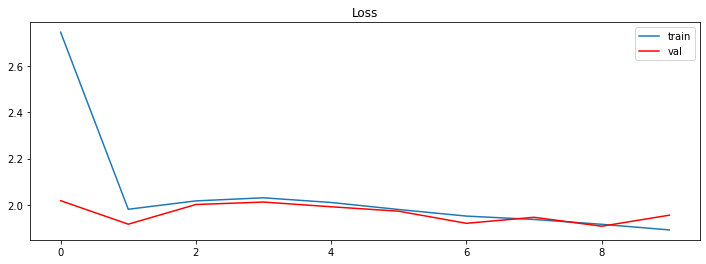

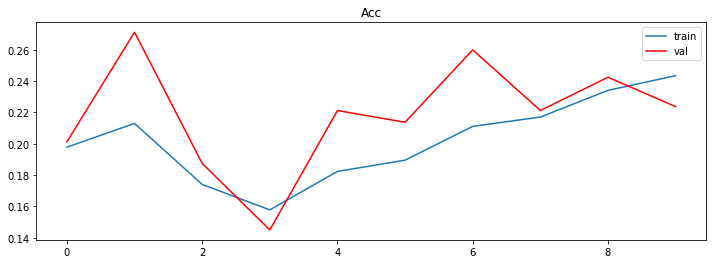

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()